# Testing Sorting Algorithms Speed in C

In [1]:
from ctypes import cdll, CFUNCTYPE, POINTER, c_char_p, c_int, c_void_p, Structure
import os
import random
import string
import timeit

In [2]:
# Load My Library
lib_path = os.path.abspath("../build/liblcthw.so")
print(lib_path)
c_lib = cdll.LoadLibrary(lib_path)

# Function prototype
COMPARE_FUNC = CFUNCTYPE(c_int, c_char_p, c_char_p)

# Get `strcmp`
libc = cdll.LoadLibrary('libc.so.6')
strcmp = COMPARE_FUNC(libc.strcmp)

# List struct
class List(Structure):
    pass

List._fields_ = [
    ("count", c_int),
    ("first", POINTER(List)),
    ("last", POINTER(List)),
]

# List_create
c_lib.List_create.restype = POINTER(List)

# List_push
c_lib.List_push.argtypes = [POINTER(List), c_void_p]
c_lib.List_push.restype = None

# List_des
c_lib.List_destroy.argtypes = [POINTER(List)]
c_lib.List_destroy.restype = None


/home/user/code/learn/lchw/liblcthw/build/liblcthw.so


In [3]:
# Bubble sort
c_lib.List_bubble_sort.argtypes = [POINTER(List), COMPARE_FUNC]
c_lib.List_bubble_sort.restype = c_int

# Bubble sort optimized
c_lib.List_bubble_sort_opt.argtypes = [POINTER(List), COMPARE_FUNC]
c_lib.List_bubble_sort_opt.restype = c_int

# Merge sort
c_lib.List_merge_sort.argtypes = [POINTER(List), COMPARE_FUNC]
c_lib.List_merge_sort.restype = POINTER(List)

# Merge sort bottom up
c_lib.List_merge_sort_bottomup.argtypes = [POINTER(List), COMPARE_FUNC]
c_lib.List_merge_sort_bottomup.restype = POINTER(List)

# Quick sort
c_lib.List_quick_sort.argtypes = [POINTER(List), COMPARE_FUNC]
c_lib.List_quick_sort.restype = POINTER(List)

In [4]:
symbols = string.ascii_letters + string.digits

def get_random_c_str() -> bytes:
    length = random.randint(1, 30)
    return ("".join(random.choices(symbols, k=length))).encode('ascii')

def get_list_random_c_str(count: int) -> list[bytes]:
    return [get_random_c_str() for i in range(count)]

def create_random_c_list(count: int) -> POINTER:
    values = get_list_random_c_str(count)
    lst = c_lib.List_create()
    for v in values:
        c_lib.List_push(lst, c_char_p(v))        
    return lst

algo_list = {
    # "Bubble Sort": c_lib.List_bubble_sort,
    # "Bubble Sort Optimized": c_lib.List_bubble_sort_opt,
    "Merge Sort": c_lib.List_merge_sort,
    "Merge Sort Bottom Up": c_lib.List_merge_sort_bottomup,
    "Quick Sort": c_lib.List_quick_sort
}

def test_sorting_algorithms(start: int, step: int, max_elem: int) -> dict[str, tuple[list[int], list[int]]]:
    result = {k: ([], [],) for k in algo_list.keys()}
    for i in range(start, max_elem, step):
        values = get_list_random_c_str(i)
        for alg_name, alg in algo_list.items():
            lst = c_lib.List_create()
            for v in values:
                c_lib.List_push(lst, c_char_p(v))
            times = timeit.timeit(lambda: alg(lst, strcmp), number=1)
            result[alg_name][0].append(i)
            result[alg_name][1].append(times)
            # c_lib.List_destroy(lst)
    return result

In [8]:
x = test_sorting_algorithms(500, 50, 1000)
# x = test_sorting_algorithms(500, 50, 1000)

In [9]:
x

{'Bubble Sort': ([500, 550, 600, 650, 700, 750, 800, 850, 900, 950],
  [0.0921983690000161,
   0.10445913200010182,
   0.12554349499987438,
   0.14619830099991304,
   0.16530280300003142,
   0.17327790899980755,
   0.18823944299992945,
   0.22280038999997487,
   0.24497657499978231,
   0.2791368899997906]),
 'Bubble Sort Optimized': ([500, 550, 600, 650, 700, 750, 800, 850, 900, 950],
  [0.036825567000050796,
   0.04345132999969792,
   0.053326695000123436,
   0.05394045000002734,
   0.06722858700004508,
   0.07065205900016736,
   0.08065155800022694,
   0.09058136700014074,
   0.10226036699987162,
   0.11303110200014999]),
 'Merge Sort': ([500, 550, 600, 650, 700, 750, 800, 850, 900, 950],
  [0.0012908720000268659,
   0.0013824950001435354,
   0.0015682680000281835,
   0.0014600730000893236,
   0.0016321189996233443,
   0.0017657230000622803,
   0.0018739690003712894,
   0.0020051789997523883,
   0.0023073319998729858,
   0.0023026429998935782]),
 'Merge Sort Bottom Up': ([500, 550, 6

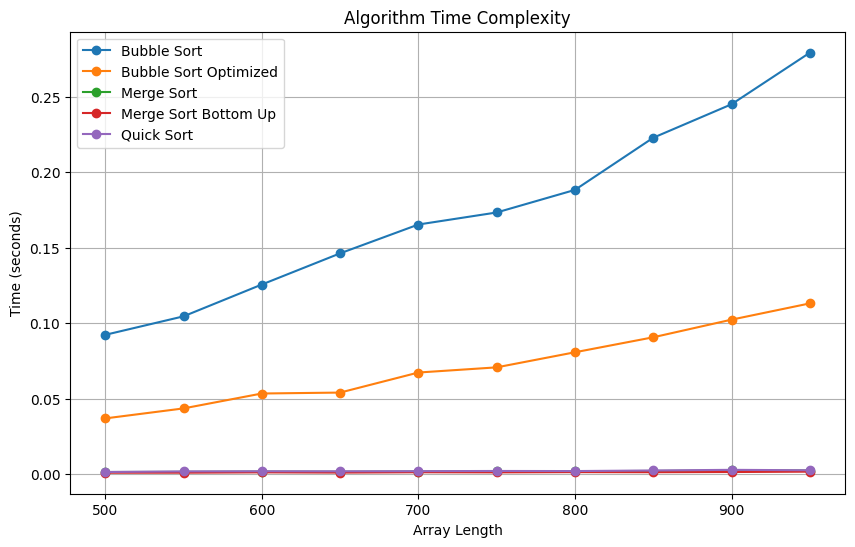

In [10]:
import matplotlib.pyplot as plt

type results = dict[str, tuple[list[int], list[int]]]
def plot_time_complexity(res: results, algorithm_name="Algorithm"):
    plt.figure(figsize=(10, 6))
    for k, v in res.items():
        plt.plot(v[0], v[1], marker='o', label=k)
    plt.xlabel('Array Length')
    plt.ylabel('Time (seconds)')
    plt.title(f'{algorithm_name} Time Complexity')
    plt.grid(True)
    plt.legend()
    plt.show()

# Example usage:
plot_time_complexity(x)